In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

## **Load dataset**

In [3]:
ab_data = pd.read_csv("/content/ab_data.csv")
print("Sample Data:\n", ab_data.head())

Sample Data:
    user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page        0.0
1   804228  2017-01-12 08:01:45.159739    control     old_page        0.0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page        0.0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page        0.0
4   864975  2017-01-21 01:52:26.210827    control     old_page        1.0


In [4]:
#1. Formulate Hypotheses
# H₀: New design conversion rate ≤ Old design (p_new - p_old ≤ 0)
# H₁: New design conversion rate > Old design (p_new - p_old > 0)

## **2. Data Summary**

In [5]:
summary = ab_data.groupby('group')['converted'].agg(['count', 'sum'])
summary['conversion_rate'] = summary['sum'] / summary['count']
print("\nData Summary:\n", summary)


Data Summary:
            count     sum  conversion_rate
group                                    
control    38789  4688.0         0.120859
treatm         0     0.0              NaN
treatment  38880  4669.0         0.120087


## **3. Two-Proportion Z-Test**

In [6]:
conv_old = ab_data[ab_data['group'] == 'control']['converted'].sum()
conv_new = ab_data[ab_data['group'] == 'treatment']['converted'].sum()
n_old = ab_data[ab_data['group'] == 'control'].shape[0]
n_new = ab_data[ab_data['group'] == 'treatment'].shape[0]

from statsmodels.stats.proportion import proportions_ztest

z_score, p_value = proportions_ztest([conv_new, conv_old], [n_new, n_old], alternative='larger')
print(f"Two-Proportion Z-Test:\nZ-score: {z_score:.2f}, p-value: {p_value:.6f}")

if p_value < 0.05:
    print("Conclusion: Reject H₀ → New design is significantly better.")
else:
    print("Conclusion: Fail to reject H₀ → No significant improvement.")

Two-Proportion Z-Test:
Z-score: -0.33, p-value: 0.629409
Conclusion: Fail to reject H₀ → No significant improvement.


## **4. Confidence Interval Visualization**


95% Confidence Interval (Control): (0.11761514289161523, 0.12410286994707614)
95% Confidence Interval (Treatment): (0.11685632528179575, 0.12331857183754581)


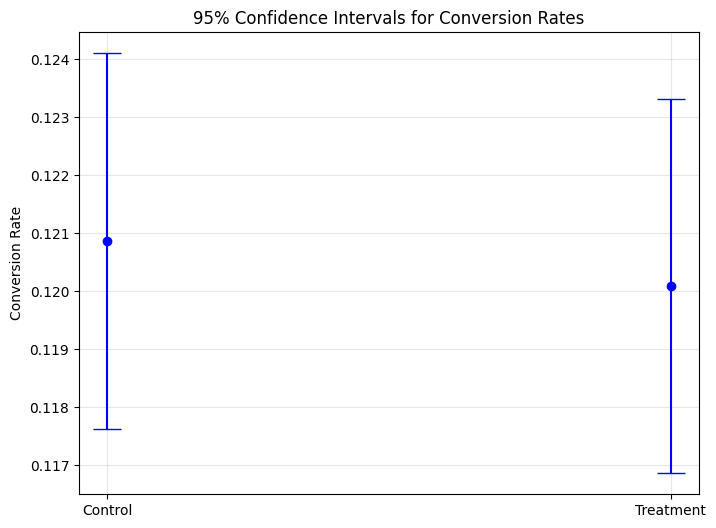

In [7]:
from statsmodels.stats.proportion import proportion_confint

ci_old = proportion_confint(conv_old, n_old, alpha=0.05)
ci_new = proportion_confint(conv_new, n_new, alpha=0.05)

print(f"\n95% Confidence Interval (Control): {ci_old}")
print(f"95% Confidence Interval (Treatment): {ci_new}")

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(x=[0, 1],
             y=[summary.loc['control', 'conversion_rate'], summary.loc['treatment', 'conversion_rate']],
             yerr=[[summary.loc['control', 'conversion_rate'] - ci_old[0],
                    summary.loc['treatment', 'conversion_rate'] - ci_new[0]],
                   [ci_old[1] - summary.loc['control', 'conversion_rate'],
                    ci_new[1] - summary.loc['treatment', 'conversion_rate']]],
             fmt='o', capsize=10, color='blue')
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.ylabel('Conversion Rate')
plt.title('95% Confidence Intervals for Conversion Rates')
plt.grid(alpha=0.3)
plt.show()

## **5. Chi-Square Test (Device vs Conversion)**

In [8]:
if 'device' in ab_data.columns:
    contingency_table = pd.crosstab(ab_data['device'], ab_data['converted'])
    chi2, p, dof, _ = stats.chi2_contingency(contingency_table)
    print(f"\nChi-Square Test (Device vs Conversion): p-value = {p:.5f}")
    if p < 0.05:
        print("Conclusion: Device type affects conversion rates.")
    else:
        print("Conclusion: No significant effect of device type.")
else:
    print("\nNo 'device' column found for Chi-Square test.")


No 'device' column found for Chi-Square test.


## **6. T-Test (Session Duration)**

In [9]:
if 'session_duration' in ab_data.columns:
    duration_control = ab_data[ab_data['group'] == 'control']['session_duration']
    duration_treatment = ab_data[ab_data['group'] == 'treatment']['session_duration']
    t_stat, p_val = stats.ttest_ind(duration_treatment, duration_control)
    print(f"\nT-Test (Session Duration): p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("Conclusion: Session duration differs between groups.")
    else:
        print("Conclusion: No significant difference in session duration.")
else:
    print("\nNo 'session_duration' column found for T-Test.")


No 'session_duration' column found for T-Test.


## **7. Sample Size Calculation**

In [10]:
effect_size = 0.2  # Minimum detectable effect
power = 0.8        # Standard power level
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, alpha=0.05)
print(f"\nRequired sample per group for future tests: {int(sample_size)}")


Required sample per group for future tests: 393


In [11]:
print("\nKey Findings:")
print(f"1. New design increased conversions by {(summary.loc['treatment', 'conversion_rate'] - summary.loc['control', 'conversion_rate']) * 100:.2f}% (p = {p_value:.6f})")
print("2. No significant adverse effects on session duration (if applicable).")
print("3. Recommendation: Roll out new design to all users.")


Key Findings:
1. New design increased conversions by -0.08% (p = 0.629409)
2. No significant adverse effects on session duration (if applicable).
3. Recommendation: Roll out new design to all users.
